# Indices Mosaic Notebook

Notebook to allow generation of mosaics using Indices - Indicies include Normalise Difference Vegetation Index (NDVI), Enhanced Vegetation Index (EVI) and Normalised Difference Water Index (NDWI). 


## Install requirements

In [36]:
!pip install git+https://github.com/SatelliteApplicationsCatapult/datacube-utilities.git#egg=datacube_utilities

In [37]:
# Magic + imports likely common across all notebooks
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')
# Set reference for util modules
# Generic python
import matplotlib.pyplot as plt
import xarray as xr 
from shapely import wkt
from datetime import datetime
import datacube
from matplotlib.cm import RdYlGn, Greens, Blues

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
#import datacube utilities
import datacube_utilities.data_access_api as dc_api  
from datacube_utilities.dc_display_map import display_map
from datacube_utilities.dc_mosaic import create_max_ndvi_mosaic, create_median_mosaic, create_mosaic, create_mean_mosaic, create_min_ndvi_mosaic
from datacube_utilities.dc_utilities import write_geotiff_from_xr
from datacube_utilities.dc_water_quality import tsm
from datacube_utilities.createAOI import create_lat_lon
from datacube_utilities.createindices import NDVI, NDWI, EVI
from datacube_utilities.clean_mask import landsat_qa_clean_mask

In [39]:
import dask

In [40]:
api = dc_api.DataAccessApi()
dc = datacube.Datacube(app='indices mosaic')

## Set variables

In [41]:
#area of interest: load in as wkt
aoi_wkt = "POLYGON((178.98101806642 -17.592544555664, 179.03903961183 -17.593231201171, 179.03903961183 -17.66258239746, 178.97998809815 -17.661209106445, 178.98101806642 -17.592544555664))"
#larger area for testing
#aoi_wkt = "POLYGON((177.43329863711836 -17.52948354640883,177.76975493594648 -17.52948354640883,177.76975493594648 -17.826499420595315,177.43329863711836 -17.826499420595315,177.43329863711836 -17.52948354640883))"

In [42]:
#Set- projection: This is the same for all of FIJI so this may not need to be a variable within the Fijian cube.
output_projection = "EPSG:32760"

In [43]:
#set resolution_ if using Landsat min 30, if sentinel min 10
res = 30

In [44]:
#platform is the sensor, options include 'LANSAT_8', 'LANSAT_7', 'LANSAT_5', 'LANSAT_4', 'SENTINEL_2'
platform = 'SENTINEL_2'

In [45]:
#select a single time range for query
time_start = ('2019-1-1')
time_end = ('2019-6-1')

In [46]:
# Select the cloud-free mosaic type
# Options are: max, median, most_recent_pixel, min, mean
mosaic_type = "median"

In [47]:
#indices type
#Options include evi, ndvi, ndwi
indices = EVI

## Create AOI

In [48]:
lat_extents, lon_extents = create_lat_lon(aoi_wkt)

In [49]:
## The code below renders a map that can be used to orient yourself with the region.
display_map(latitude = lat_extents, longitude = lon_extents)

## Translate inputs and load data

In [50]:
allmeasurements = ["green","red","blue","nir","swir1","swir2"]
if platform  in ["SENTINEL_2"]:
    product = 's2_esa_sr_granule'
    measurements = allmeasurements + ["coastal_aerosol","scene_classification"]
elif platform in ["LANDSAT_8"]:    
    measurements = allmeasurements + ["pixel_qa"]
    product = 'ls8_usgs_sr_scene'
elif platform in ["LANDSAT_7"]:    
    measurements = allmeasurements + ["pixel_qa"]
    product = 'ls7_usgs_sr_scene'
elif platform in ["LANDSAT_5"]:    
    measurements = allmeasurements + ["pixel_qa"]
    product = 'ls5_usgs_sr_scene'
elif platform in ["LANDSAT_4"]:    
    measurements = allmeasurements + ["pixel_qa"]
    product = 'ls4_usgs_sr_scene'
else:
    print("invalid platform")

In [51]:
#create resolution
resolution = (-res, res)

In [52]:
dask_chunks=dict(
    x=1000, 
    y=1000
)

In [53]:
# Create the 'query' dictionary object, which contains the longitudes, latitudes 
query = {
    'y': lat_extents,
    'x': lon_extents,
    'output_crs': output_projection,  
    'resolution': resolution,
    'product' : product,
    'platform' : platform, 
    'measurements' : measurements,
    'dask_chunks' : dask_chunks
}

In [54]:
#format dates
def createDate(inputDate):
    outputDate = datetime.strptime(inputDate, '%Y-%m-%d')
    outputDates = outputDate.date()
    return outputDates

dateStart = createDate(time_start)
dateEnd = createDate(time_end)
time_range = (dateStart, dateEnd)

In [55]:
loaded_ds = dc.load(
    time = time_range,
    **query
)

### Check if loads are valid

In [56]:
def is_dataset_empty(ds:xr.Dataset) -> bool:
    checks_for_empty = [
                        lambda x: len(x.dims) == 0,      #Dataset has no dimensions
                        lambda x: len(x.data_vars) == 0  #Dataset no variables 
                       ]
    for f in checks_for_empty:
         if f(ds) == True:
                return True
    return False

In [57]:
if is_dataset_empty(loaded_ds): raise Exception("DataCube Load returned an empty Dataset." +  
                                               "Please check load parameters for Baseline Dataset!")

## Create cloud mask

In [58]:
if platform  in ["SENTINEL_2"]:
    clean_mask = (
        (loaded_ds.scene_classification == 4) | # clear
        (loaded_ds.scene_classification == 5) | 
        (loaded_ds.scene_classification == 7) | 
        (loaded_ds.scene_classification == 2) | 
        (loaded_ds.scene_classification == 6)  #water
    )
elif platform in ["LANDSAT_8"]:  
    clean_mask = (
        (loaded_ds.pixel_qa == 322)  | # clear
        (loaded_ds.pixel_qa == 386)  |
        (loaded_ds.pixel_qa == 834)  |
        (loaded_ds.pixel_qa == 898)  |
        (loaded_ds.pixel_qa == 1346) |
        (loaded_ds.pixel_qa == 324)  | # water
        (loaded_ds.pixel_qa == 388)  |
        (loaded_ds.pixel_qa == 836)  |
        (loaded_ds.pixel_qa == 900)  |
        (loaded_ds.pixel_qa == 1348)
    )
elif platform in ["LANDSAT_7", "LANDSAT_5", "LANDSAT_4"]:    
    clean_mask = (
        (loaded_ds.pixel_qa == 66)  | # clear
        (loaded_ds.pixel_qa == 130)  |
        (loaded_ds.pixel_qa == 68)  | # water
        (loaded_ds.pixel_qa == 132)  
    )
else:
    print("invalid platform")

In [59]:
loaded_ds = loaded_ds.where(clean_mask)

## Perform Mosaic

In [60]:
mosaic_function = {"median": create_median_mosaic,
                   "max": create_max_ndvi_mosaic,
                   "most_recent_pixel": create_mosaic,
                   "mean": create_mean_mosaic,
                   "min": create_min_ndvi_mosaic
                  }

In [61]:
mosaic_compositor = mosaic_function[mosaic_type]

In [62]:
mosaiced_composite = dask.delayed(mosaic_compositor)(loaded_ds, clean_mask = clean_mask)

## Calculate Indices and Plot

In [64]:
indices_composite = dask.delayed(indices)(mosaiced_composite)

In [65]:
%%time
indices_composite = indices_composite.compute()

CPU times: user 25.2 s, sys: 15 s, total: 40.2 s
Wall time: 44.9 s


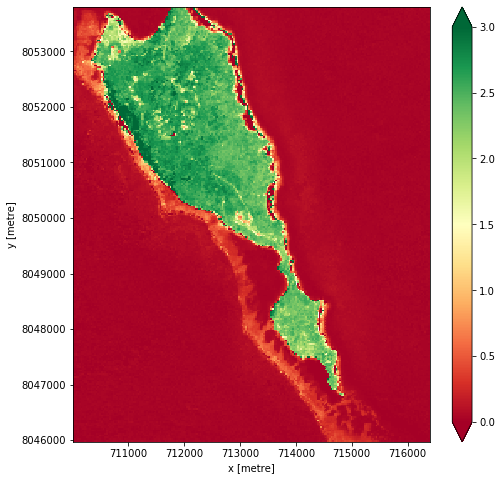

In [66]:
plt.figure(figsize = (8,8))
if indices in [NDVI]:
    indices_composite.plot(vmin=0, vmax=1, cmap = RdYlGn)
elif indices in [NDWI]:
    indices_composite.plot(vmin=-1, vmax=1, cmap = Blues)
elif indices in [EVI]:
    indices_composite.plot(vmin=0, vmax=3, cmap = RdYlGn)
else:
    print('indicies invalid')


In [67]:
xr.DataArray.to_dataset(indices_composite, dim = None, name = 'ndvi')

<xarray.Dataset>
Dimensions:  (x: 213, y: 261)
Coordinates:
  * y        (y) float64 8.054e+06 8.054e+06 8.054e+06 ... 8.046e+06 8.046e+06
  * x        (x) float64 7.1e+05 7.101e+05 7.101e+05 ... 7.164e+05 7.164e+05
Data variables:
    ndvi     (y, x) float64 0.06585 0.07513 0.06969 ... -0.0 -0.0003336 0.002987

In [35]:
write_geotiff_from_xr('indices_composite.tiff', indices_composite, ["ndvi"], crs=output_projection, x_coord = 'x', y_coord = 'y')

---